In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def filt(image, kernel):
    image_dims = image.shape
    kernel_dims = kernel.shape
    out = np.zeros((image.shape[0] - kernel.shape[0], image.shape[1] - kernel.shape[1]))
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    out[i][j] += (image[i+k][j+l]*kernel[k][l])
    return out

In [3]:
#Problem 1 - create a my_imfilter function
def my_imfilter(image, kernel):
    kernel_dims = kernel.shape
    image_dims = image.shape
    dims = len(image_dims)
    if kernel_dims[0] % 2 == 0 or kernel_dims[1] % 2 == 0:
        raise ValueError("Both Kernel Dimensions Must Be Odd")
    if dims < 2 or dims > 3:
        raise ValueError("Only Grayscale and RGB Images are Supported")
    
    if dims == 2:
        print("Image is grayscale")
        image = np.pad(image, ((kernel.shape[0]//2, kernel.shape[0]//2+1), 
                               (kernel.shape[1]//2, kernel.shape[1]//2+1)))
        out = filt(image, kernel)
    if dims == 3:
        print("Image is RGB")
        b, g, r = cv2.split(image)
        for i in (b, g, r):
            i = np.pad(i, ((kernel.shape[0]//2, kernel.shape[0]//2+1), 
                                   (kernel.shape[1]//2, kernel.shape[1]//2+1)))
        b_conv = filt(b, kernel)
        g_conv = filt(g, kernel)
        r_conv = filt(r, kernel)
        out = cv2.merge((b_conv, g_conv, r_conv))
    return out

Grayscale Test
Image is grayscale
Original Image Shape: (241, 321)
Output Image Shape: (241, 321)
Output Shape = Input Shape? True


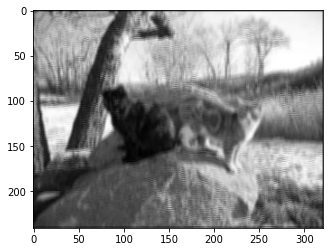

In [11]:
def main():
    print("Grayscale Test")
    gray = cv2.imread("sample1.jpg", 0)
    kernel1 = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    kernel2 = np.array([[1, 1, 1], [0, 0, 0], [1, 1, 1], [0, 0, 0], [1, 1, 1]])
    out = my_imfilter(gray, kernel2)
    print("Original Image Shape: " + str(gray.shape)) 
    print("Output Image Shape: " + str(out.shape))
    print("Output Shape = Input Shape? " + str((out.shape==gray.shape)))
    plt.imshow(out, cmap = "gray")
    
main()

In [ ]:
#Problem 2
